In [13]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install pydot
!rm -rf ./logs/ 
!pip install tensorflow_hub

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Regression with Keras

So far we have mainly looked at the digits dataset, which is a classification problem with *Keras*, however it is also easy to create a regression model, we simply change the output to a single `tf.keras.layers.Dense` layer with one unit and no activation function. This outputs a scalar value that is unbounded, and is the sum of the weighted inputs from the previous layer.

I.e. a model of the form

In [2]:
from tensorflow import keras


def new_model():
    units = 32
    model = keras.Sequential([
        keras.layers.Dense(units, activation='relu', input_shape=[13]),
        keras.layers.Dense(units, activation='relu'),
        keras.layers.Dense(1)
    ])

    # Compile the regression model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


model = new_model()

We can train such a model on a the boston housing dataset, i.e. the 

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.boston_housing.load_data()

In [4]:
epochs = 1201

# Train the regression model
history = model.fit(X_train, y_train, epochs=epochs,
                    verbose=0, validation_split=0.2)

We can visualise the models training metrics over each epoch by the attributes of the `history` object

In [5]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,1111.575366,26.595234,1111.575439,686.753519,19.790129,686.753540,0
1,677.874394,20.452900,677.874390,455.738347,16.327723,455.738342,1
2,473.759852,17.431711,473.759857,342.918900,14.636466,342.918884,2
3,358.237170,15.536910,358.237183,275.356677,13.652861,275.356689,3
4,287.979154,14.201866,287.979156,237.362035,12.887597,237.362030,4
...,...,...,...,...,...,...,...
1196,23.501027,3.389975,23.501026,33.075552,3.901746,33.075550,1196
1197,23.784614,3.409444,23.784613,31.768792,3.873249,31.768793,1197
1198,24.227158,3.478685,24.227158,30.327556,4.038062,30.327559,1198
1199,23.676687,3.450481,23.676687,31.166492,3.906418,31.166492,1199


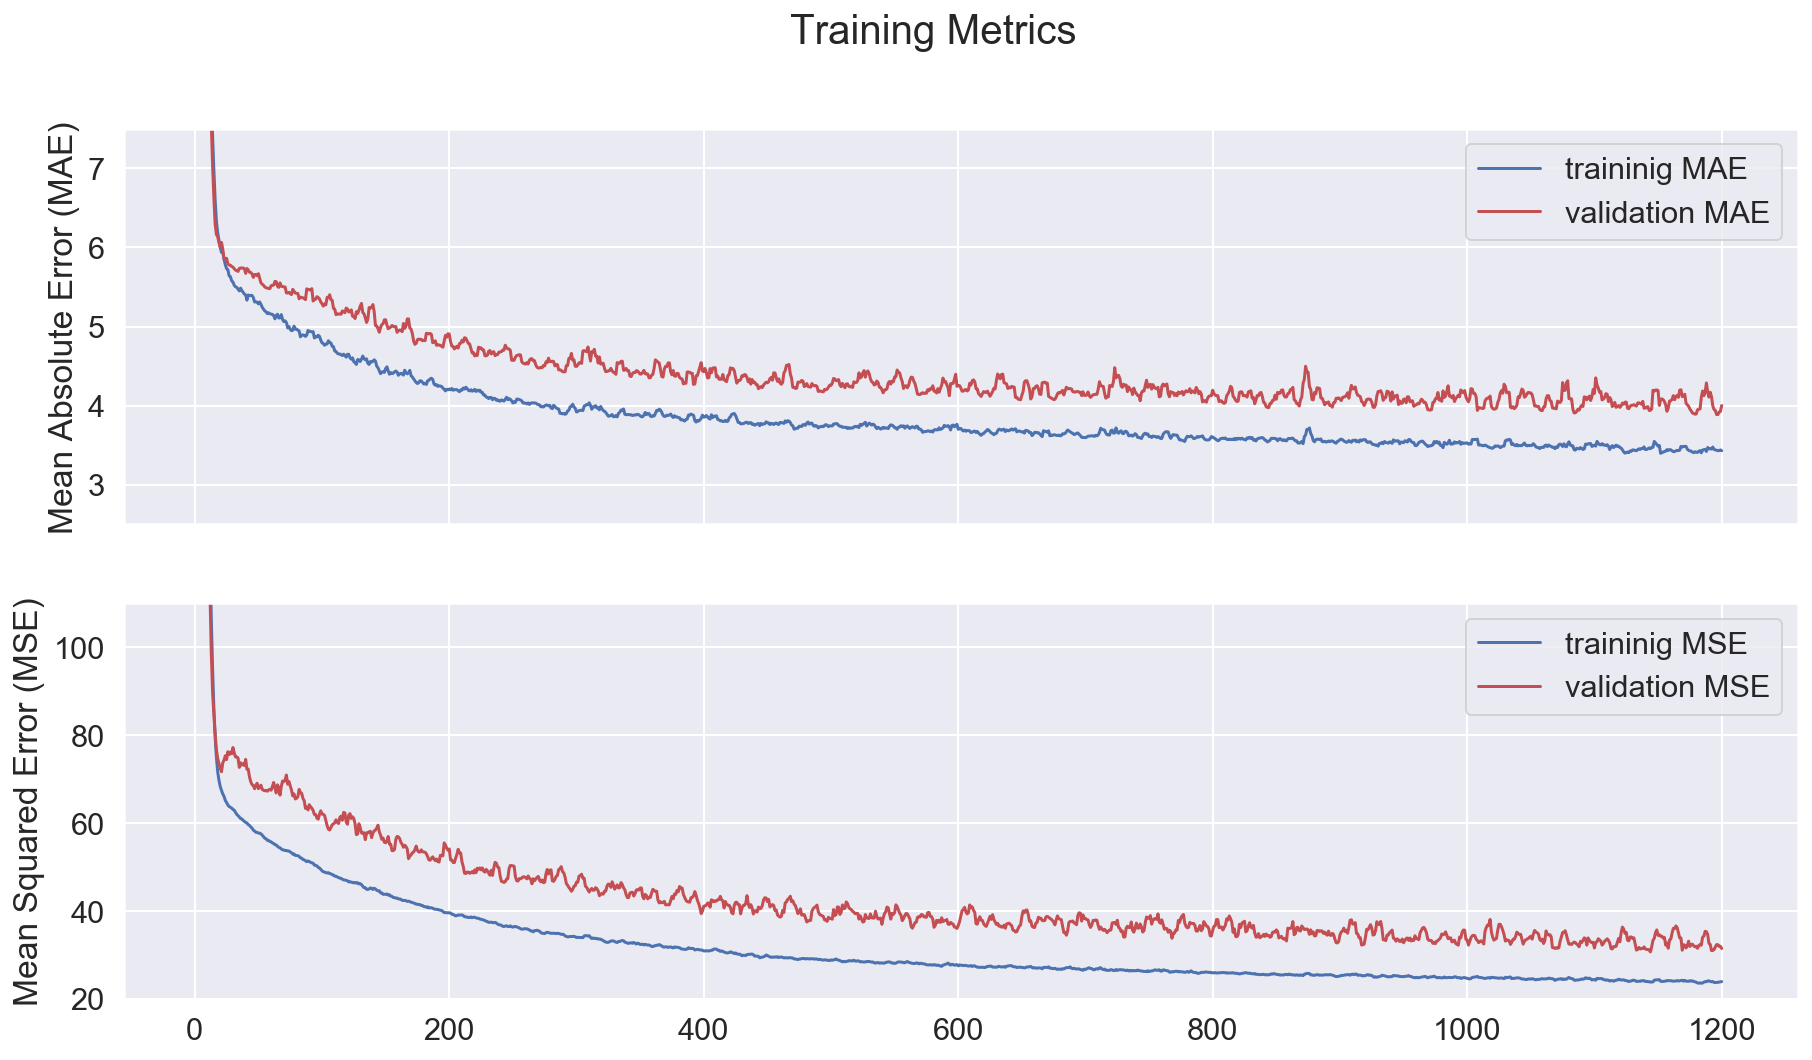

In [6]:
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 5

axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].plot(history_df['mae'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_mae'].rolling(epochs_to_mean).mean(), '-r')
axes[0].set_ylim(2.5, 7.5)
axes[0].legend(['traininig MAE', 'validation MAE'])

axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].plot(history_df['mse'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_mse'].rolling(epochs_to_mean).mean(), '-r')
axes[1].set_ylim(20, 110)
axes[1].legend(['traininig MSE', 'validation MSE'])
plt.show()

The plot above shows that that the losses plateau quickly, and that after about 400 epochs the validation mean squared error loss is not reducing. To optimize training, we can use the *EarlyStopping* callback, and set it so that if there is no reduction in the validation MSE after a set amount of epochs we can automatically stop training.

In [7]:
model = new_model()

# Here the patience parameter is the amount of epochs to check for reduction in the validation error
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(X_train, y_train,
                          epochs=epochs, validation_split=0.2, verbose=0,
                          callbacks=[early_stop])

In [8]:
history_df = pd.DataFrame(early_history.history)
history_df['epoch'] = early_history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,2637.094924,50.227222,2637.094971,2256.366042,46.568237,2256.366211,0
1,1795.394457,41.138664,1795.394531,1603.363661,38.906647,1603.363770,1
2,1260.785337,34.014965,1260.785278,1148.517332,32.486065,1148.517334,2
3,877.418422,27.784779,877.418457,790.701403,26.320816,790.701416,3
4,585.430867,21.891754,585.430908,523.819385,20.518997,523.819397,4
...,...,...,...,...,...,...,...
83,59.264463,5.315631,59.264465,72.663412,5.688503,72.663414,83
84,59.422598,5.336522,59.422600,75.545901,5.636032,75.545898,84
85,59.182831,5.327860,59.182831,71.679116,5.739611,71.679115,85
86,59.753177,5.395680,59.753181,75.048578,5.632812,75.048576,86


We can see that it stopped at about epoch before our defined number of epochs, saving computation and resources, plotting the losses from the training below

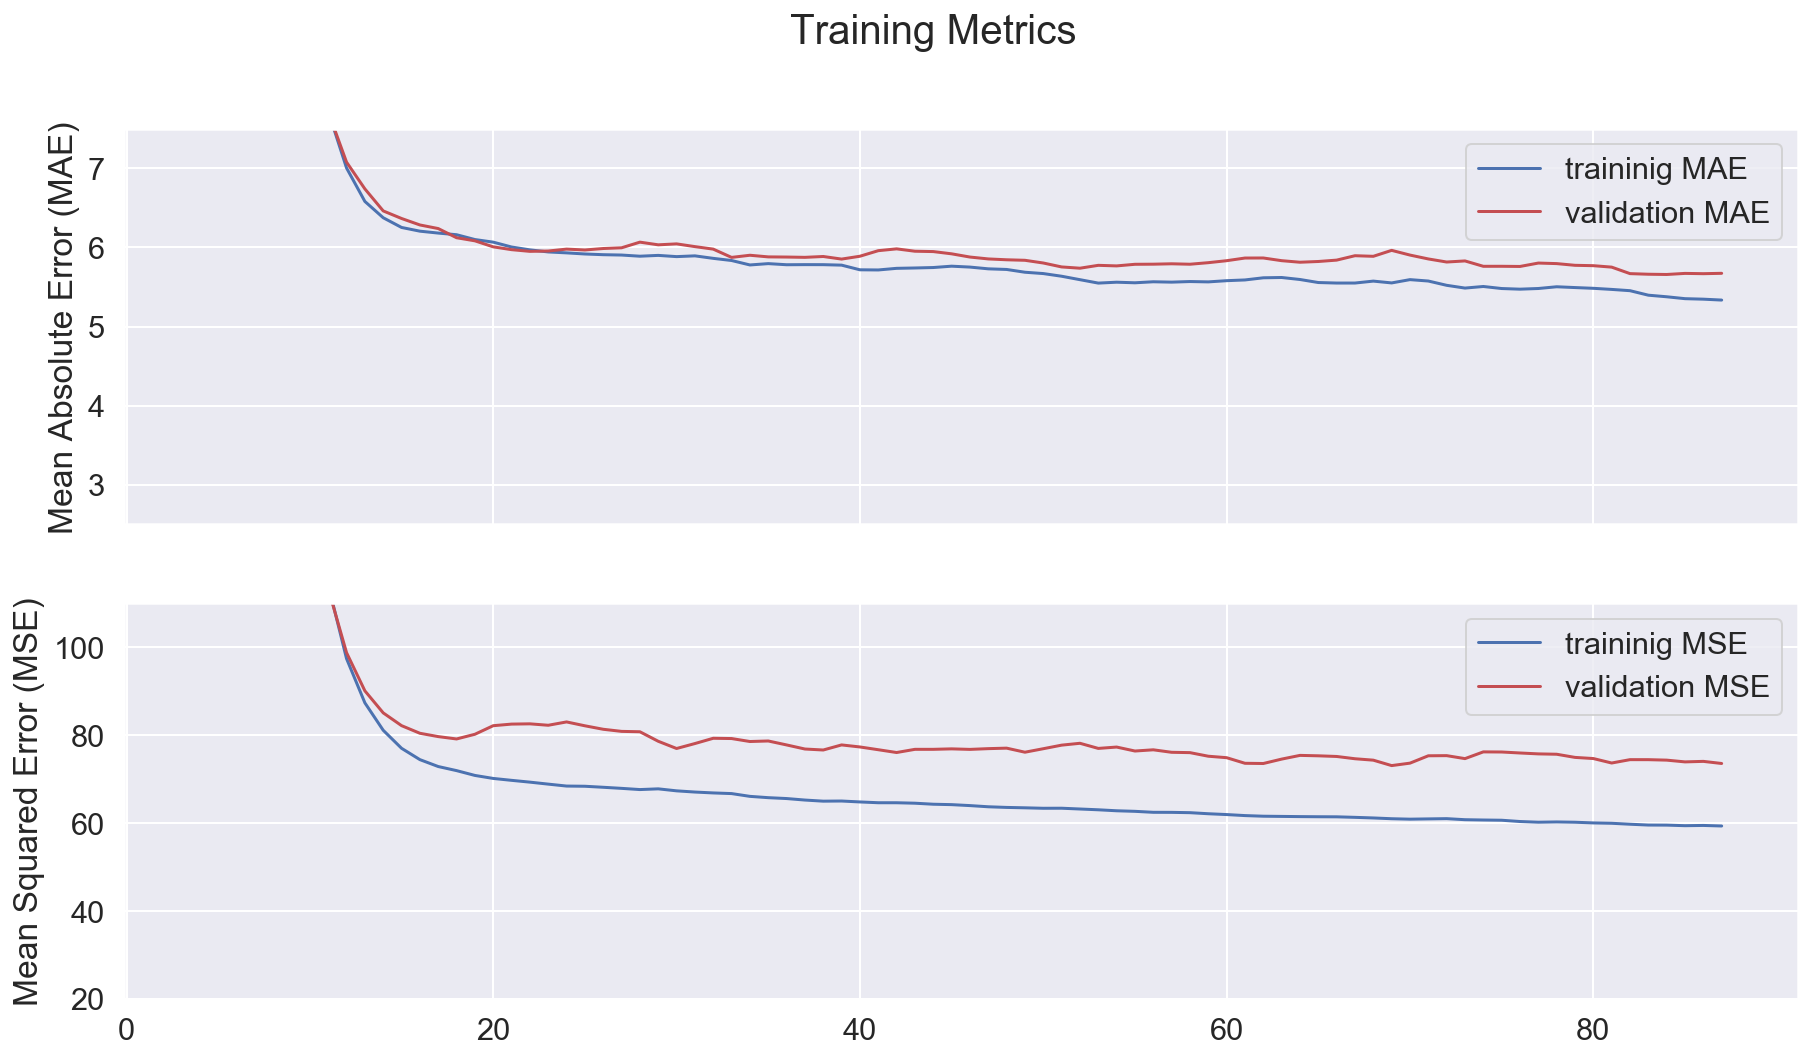

In [9]:
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 5

axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].plot(history_df['mae'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_mae'].rolling(epochs_to_mean).mean(), '-r')
axes[0].set_ylim(2.5, 7.5)
axes[0].legend(['traininig MAE', 'validation MAE'])

axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].plot(history_df['mse'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_mse'].rolling(epochs_to_mean).mean(), '-r')
axes[1].set_ylim(20, 110)
axes[1].legend(['traininig MSE', 'validation MSE'])
plt.show()

We can evaluate the model on the test set as well

In [10]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)
print("Test Mean Absolute Error: {:5.2f} in $1000's".format(mae))

102/102 - 0s - loss: 66.9267 - mae: 5.9321 - mse: 66.9267
Test Mean Absolute Error:  5.93 in $1000's


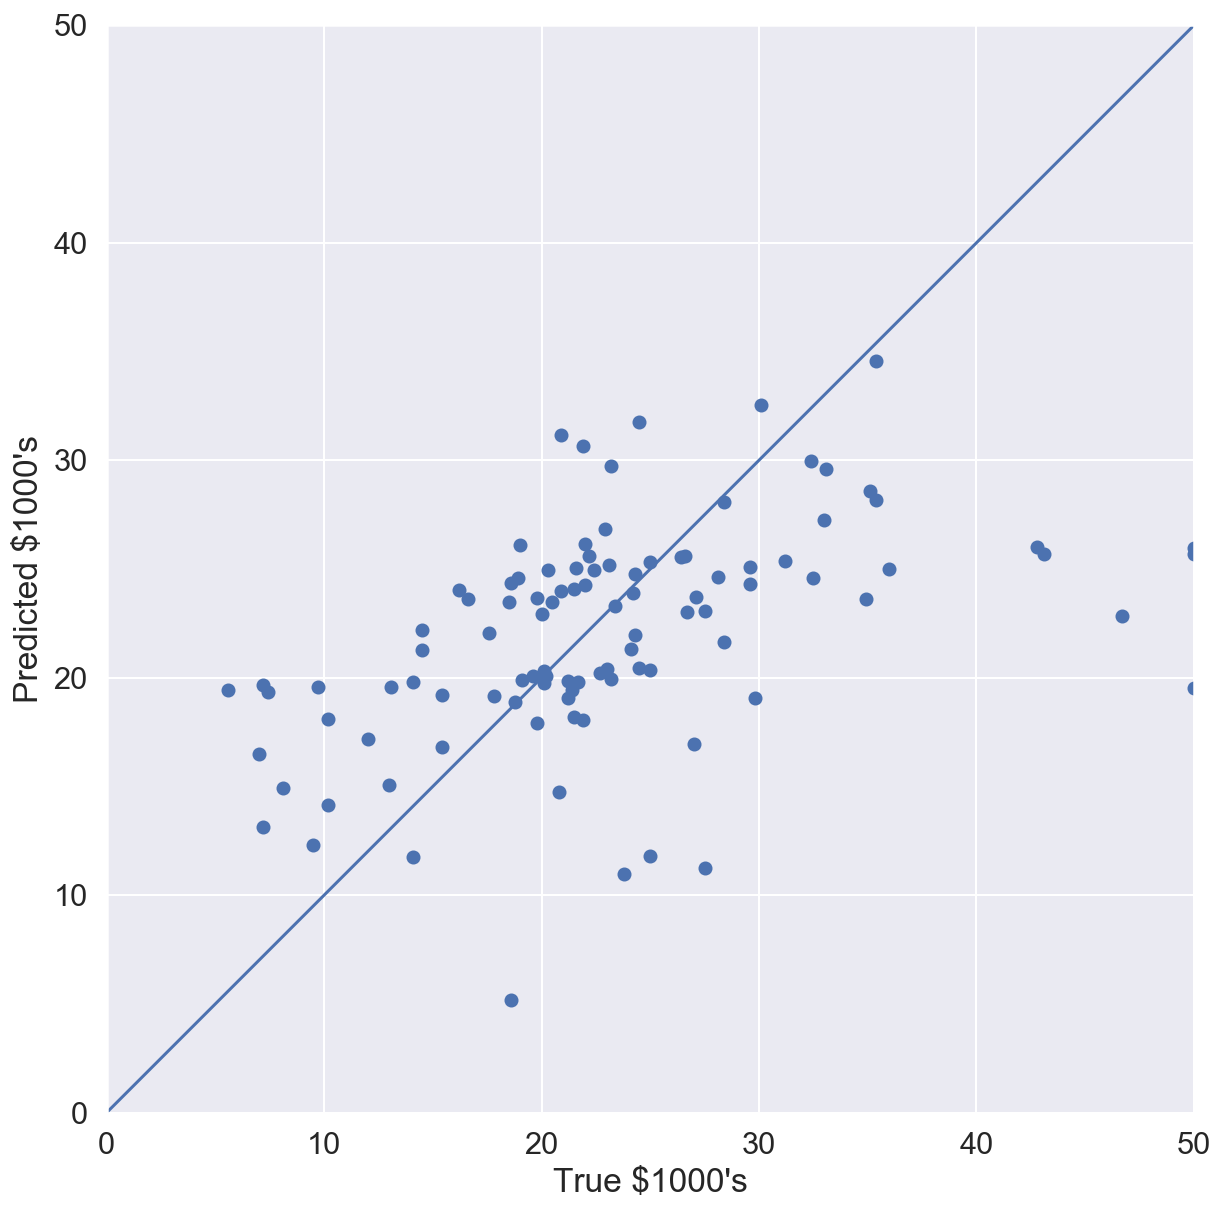

In [11]:
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(10,10))
plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel("True $1000's")
plt.ylabel("Predicted $1000's")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()

Our model predicts suitable as a first pass. 

We can look our error distribution of the predicted against test output values

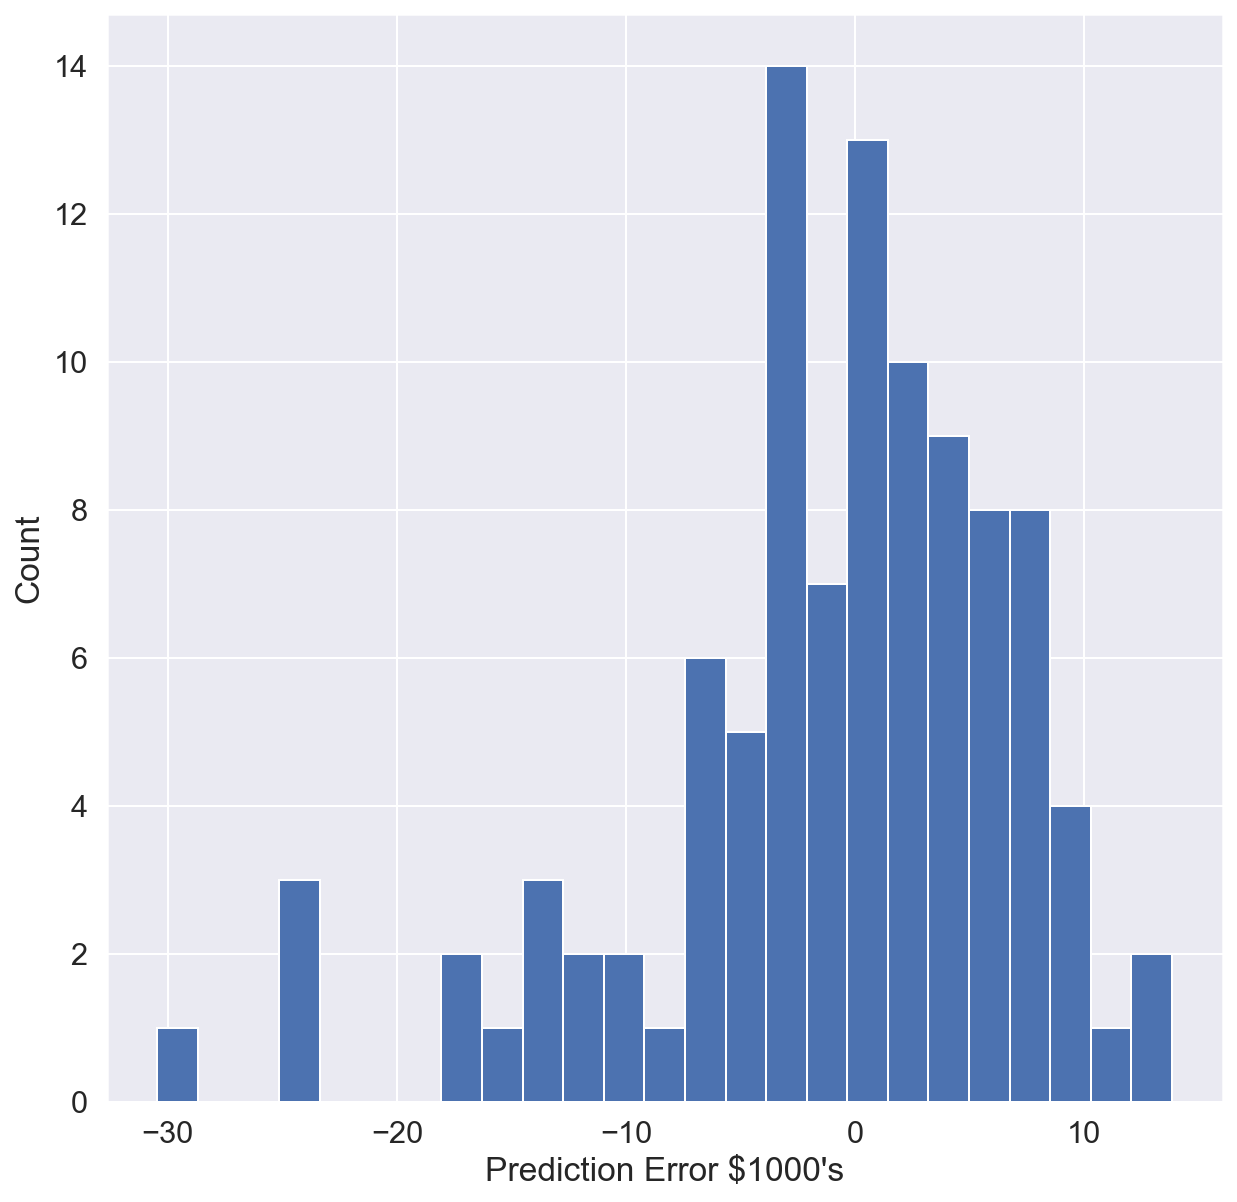

In [12]:
error = y_pred - y_test
plt.figure(figsize=(10, 10))
plt.hist(error, bins=25)
plt.xlabel("Prediction Error $1000's")
plt.ylabel("Count")
plt.show()

The error distribution shows approximate gaussian shape around zero, however with some large errors where the model couldn't predict the larger values

# Transfer Learning (with Keras)

Transfer learning (TL) is a approach in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

Transfer learning can be used to leverage large neural networks pre-trained on a similar problem with a large dataset. If such a model exists we can then apply it to our problem, either as an initialization or a fixed feature extractor for the problem. There are two types of Transfer Learning scenarios:
* Pre-trained model as a feature extractor. We take a pre-trained model, remove the last fully-connected layer and treat the model as a feature extractor for our dataset (by freezing these lower pre-trained layers). We can often train our own single layer on the output or even train a linear classifier (With SciKit-Learn).
* Fine-tuning the pre-trained model, do the above replacing the last layer and not freezing the lower layers, so when we train the complete model we also update the weights for the pre-trained model (its also possible to fix some of the lower layers, to avoid overfitting).

We can find pre-trained models in so called *Model Zoo's*, however TensorFlow has it's own library of pre-trained models [TensorFlow Hub](https://tfhub.dev/). There are also other pre-trained collections of saved models such as [TensorFlow Model Garden](https://github.com/tensorflow/models), [modelzoo.co](https://modelzoo.co/framework/keras) and [HuggingFace](https://github.com/huggingface/transformers) to list a few. These are useful as training some of these models, especially large models with many parameters can take amount of computational resources (Some Convnets take 2-3 weeks to train).

We use the size of our dataset (small or big), and whether it is similar to the original problem that our pre-trained model was trained on, to decide which of two approaches to choose when using transfer learning. Often the features in the pre-trained model are more generic in the early layers and then more dataset specific in the later layers of the model. Given these if we have:

|Our dataset size|Our problem is similar to the pre-trained models problem| Resolution|
|----------------|--------------------------------------------------------|-----------|
|Small|Similar|Just train the last layer and leave all other layers frozen|
|Large|Similar|Train the last later and the rest of the parameters of the pre-trained model|
|Small|Very different|Extract and use only the first few layers of the pre-trained model frozen, and add a layer and train it as normal|
|Large|Very different|Train the entire model almost from scratch, using the pre-trained weights as a starting point|

A best pratice is to use a smaller starting learning rate when performing fine-tuning training.




Wiki description

Then CNN transfer learning

& How to train such a model

& Demonstrate a task on the digits dataset using VG19 perhaps ?! I think that could be very nice


-> What about a MNIST model - I reckon I could easily use that for the digits dataset and win over it !



In [98]:
pre_trained_model = tf.keras.models.load_model('./mnist_model', compile=False)

In [99]:
pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [103]:
# Freeze the underlying layers
pre_trained_layers = pre_trained_model.layers[:-1]
for layer in pre_trained_layers:
    layer.trainable = False

# Create a new model with the pre-trained layers
model = keras.models.Sequential(
    pre_trained_layers,
    keras.layers.Dense(10, activation='softmax'),
)




In [104]:
# Loading the data
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
digits = datasets.load_digits()

(X, y) = datasets.load_digits(return_X_y=True)
X = X.astype(np.float32)
y = y.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Pre process the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# dropout_rate = 0.1
# epochs = 100
# neurons_per_layer = 8*8

# regularizer = keras.regularizers.l2(l=0.001)

# model = keras.Sequential([
#     keras.layers.Dropout(dropout_rate),
#     keras.layers.Dense(neurons_per_layer, activation='relu', input_shape=[
#                        8*8], kernel_initializer='he_normal', kernel_regularizer=regularizer,
#                        kernel_constraint='max_norm'),
#     keras.layers.Dropout(dropout_rate),
#     keras.layers.Dense(neurons_per_layer, activation='relu', kernel_initializer='he_normal',
#                        kernel_regularizer=regularizer, kernel_constraint='max_norm'),
#     keras.layers.Dropout(dropout_rate),
#     keras.layers.Dense(neurons_per_layer, activation='relu', kernel_initializer='he_normal',
#                        kernel_regularizer=regularizer, kernel_constraint='max_norm'),
#     keras.layers.Dense(10)
# ])

# early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(
#                   from_logits=True),
#               metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=epochs, callbacks=[early_stop],
#                     validation_split=0.2)

In [106]:
X_train[0].shape

(64,)

In [114]:
X_train[0].reshape((8,8,-1))

array([[[0.        ],
        [0.        ],
        [0.1875    ],
        [0.875     ],
        [0.0625    ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.75      ],
        [0.75      ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.1875    ],
        [1.        ],
        [0.375     ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.33333334],
        [1.        ],
        [0.125     ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.42857146],
        [1.        ],
        [0.125     ],
        [0.3125    ],
        [0.125     ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.25      ],
        [1.        ],
        [0.125     ],
        [0.75      ],


In [115]:
tf.image.resize(X_train[0].reshape((8,8,-1)), (28,28))

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.33928731e-02],
        [6.69642985e-02],
        [1.20535746e-01],
        [1.74107149e-01],
        [3.34821522e-01],
        [5.31250179e-01],
        [7.27678657e-01],
        [8.16964149e-01],
        [5.84821343e-01],
        [3.52678239e-01],
        [1.20535493e-01],
        [4.91071343e-02],
        [3.12500000e-02],
        [1.33928359e-02],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.33928731e-02],
        [6.69642985e-02],
        [1.20535746e-01],
        [

In [76]:
# Or
import tensorflow_hub as hub

module_url = "https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"
loaded = hub.load(module_url, compile=False)

TypeError: load() got an unexpected keyword argument 'compile'